<a href="https://colab.research.google.com/github/pri538/Deep-Learning-Project/blob/main/Store_Item_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [ ]:
test.columns

Index(['id', 'date', 'store', 'item'], dtype='object')

In [ ]:
train.columns

Index(['date', 'store', 'item', 'sales'], dtype='object')

In [ ]:
print(train.shape,test.shape)

(227618, 4) (45000, 4)


In [ ]:
test.tail()

,id,date,store,item
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50
44999,44999,2018-03-31,10,50


In [ ]:
print('store'	, ' values: ', train['store'].unique())
print('item'	, ' values: ', train['item'].unique())
print('store'	, ' values: ', test['store'].unique())
print('item'	, ' values: ', test['item'].unique())

store  values:  [ 1  2  3  4  5  6  7  8  9 10]
item  values:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
store  values:  [ 1  2  3  4  5  6  7  8  9 10]
item  values:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


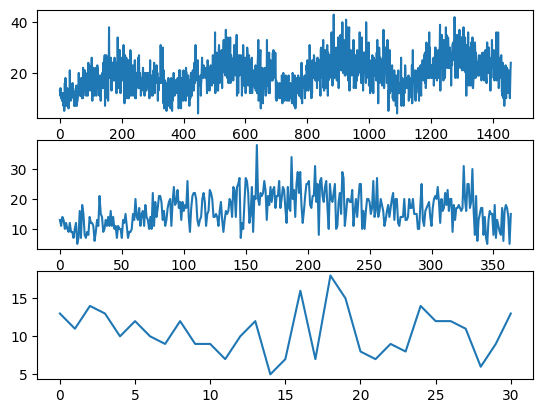

In [ ]:
plt.subplot(3, 1, 1)
plt.plot(train.sales[:365*4])
plt.subplot(3, 1, 2)
plt.plot(train.sales[:365])

plt.subplot(3, 1, 3)
plt.plot(train.sales[:31])
plt.show()

In [ ]:
rolling_mean = train.sales.rolling(window=7).mean()
print(rolling_mean.shape)
print(rolling_mean[:31])

(227618,)
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6     11.857143
7     11.285714
8     11.428571
9     10.714286
10    10.142857
11     9.714286
12     9.428571
13     9.714286
14     9.142857
15     8.428571
16     9.428571
17     9.142857
18    10.714286
19    11.428571
20    10.857143
21    11.142857
22    11.428571
23    10.285714
24    11.285714
25    10.428571
26    10.000000
27    10.428571
28    10.285714
29    10.285714
30    11.000000
Name: sales, dtype: float64


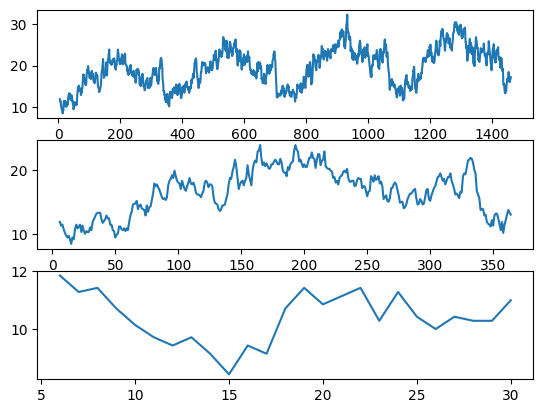

In [ ]:
rolling_mean = train.sales.rolling(window=7).mean()
plt.subplot(3, 1, 1)
plt.plot(rolling_mean[:365*4])
plt.subplot(3, 1, 2)
plt.plot(rolling_mean[:365])

plt.subplot(3, 1, 3)
plt.plot(rolling_mean[:31])
plt.show()

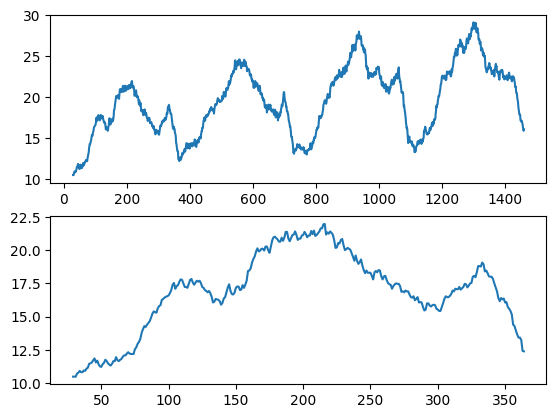

In [ ]:
rolling_mean2 = train.sales.rolling(window=30).mean()
plt.subplot(2, 1, 1)
plt.plot(rolling_mean2[:365*4])
plt.subplot(2, 1, 2)
plt.plot(rolling_mean2[:365])
plt.show()

In [ ]:
data_combine = pd.concat([train,test])

print("size of data_combine",data_combine.shape)

size of data_combine (272618, 5)


In [ ]:
data_combine['date'] = pd.to_datetime(data_combine['date'],infer_datetime_format=True)


data_combine['month'] = data_combine['date'].dt.month
data_combine['weekday'] = data_combine['date'].dt.dayofweek
data_combine['year'] = data_combine['date'].dt.year
# df['date'].dt.
data_combine['week_of_year']  = data_combine.date.dt.weekofyear

<ipython-input-15-694e08b9efbe>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data_combine['week_of_year']  = data_combine.date.dt.weekofyear


In [ ]:
data_combine['date_order'] = (data_combine['date'] - datetime.datetime(2013, 1, 1)).dt.days

In [ ]:
data_combine.head(100)

,date,store,item,sales,id,month,weekday,year,week_of_year,date_order
0,2013-01-01,1,1,13.0,NaN,1,1,2013,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2013,1,1
2,2013-01-03,1,1,14.0,NaN,1,3,2013,1,2
3,2013-01-04,1,1,13.0,NaN,1,4,2013,1,3
4,2013-01-05,1,1,10.0,NaN,1,5,2013,1,4
...,...,...,...,...,...,...,...,...,...,...
95,2013-04-06,1,1,23.0,NaN,4,5,2013,14,95
96,2013-04-07,1,1,17.0,NaN,4,6,2013,14,96
97,2013-04-08,1,1,19.0,NaN,4,0,2013,15,97
98,2013-04-09,1,1,13.0,NaN,4,1,2013,15,98


In [ ]:
data_combine['sale_moving_average_7days']=data_combine.groupby(["item","store"])['sales'].transform(lambda x: x.rolling(window=7,min_periods=1).mean())
data_combine['sale_moving_average_7days_shifted-90']=data_combine.groupby(["item","store"])['sale_moving_average_7days'].transform(lambda x:x.shift(90))

In [ ]:
data_combine['store_item_shifted-90'] = data_combine.groupby(["item","store"])['sales'].transform(lambda x:x.shift(90))
data_list2=data_combine.groupby(["item","store"])['sales'].transform(lambda x:x.shift(90))
print(data_list2)

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
44995   NaN
44996   NaN
44997   NaN
44998   NaN
44999   NaN
Name: sales, Length: 272618, dtype: float64


In [ ]:
data_combine.head(n=40)

,date,store,item,sales,id,month,weekday,year,week_of_year,date_order,sale_moving_average_7days,sale_moving_average_7days_shifted-90,store_item_shifted-90
0,2013-01-01,1,1,13.0,NaN,1,1,2013,1,0,13.000000,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2013,1,1,12.000000,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,2013,1,2,12.666667,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,2013,1,3,12.750000,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,2013,1,4,12.200000,NaN,NaN
5,2013-01-06,1,1,12.0,NaN,1,6,2013,1,5,12.166667,NaN,NaN
6,2013-01-07,1,1,10.0,NaN,1,0,2013,2,6,11.857143,NaN,NaN
7,2013-01-08,1,1,9.0,NaN,1,1,2013,2,7,11.285714,NaN,NaN
8,2013-01-09,1,1,12.0,NaN,1,2,2013,2,8,11.428571,NaN,NaN
9,2013-01-10,1,1,9.0,NaN,1,3,2013,2,9,10.714286,NaN,NaN


In [ ]:
data_combine['store_item_shifted-10'] = data_combine.groupby(["item","store"])['sales'].transform(lambda x:x.shift(10))

In [ ]:
data_combine.head(n=40)

,date,store,item,sales,id,month,weekday,year,week_of_year,date_order,sale_moving_average_7days,sale_moving_average_7days_shifted-90,store_item_shifted-90,store_item_shifted-10
0,2013-01-01,1,1,13.0,NaN,1,1,2013,1,0,13.000000,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2013,1,1,12.000000,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,2013,1,2,12.666667,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,2013,1,3,12.750000,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,2013,1,4,12.200000,NaN,NaN,NaN
5,2013-01-06,1,1,12.0,NaN,1,6,2013,1,5,12.166667,NaN,NaN,NaN
6,2013-01-07,1,1,10.0,NaN,1,0,2013,2,6,11.857143,NaN,NaN,NaN
7,2013-01-08,1,1,9.0,NaN,1,1,2013,2,7,11.285714,NaN,NaN,NaN
8,2013-01-09,1,1,12.0,NaN,1,2,2013,2,8,11.428571,NaN,NaN,NaN
9,2013-01-10,1,1,9.0,NaN,1,3,2013,2,9,10.714286,NaN,NaN,NaN


In [ ]:
data_combine.tail(n=40)

,date,store,item,sales,id,month,weekday,year,week_of_year,date_order,sale_moving_average_7days,sale_moving_average_7days_shifted-90,store_item_shifted-90,store_item_shifted-10
44960,2018-02-20,10,50,NaN,44960.0,2,1,2018,8,1876,NaN,NaN,NaN,NaN
44961,2018-02-21,10,50,NaN,44961.0,2,2,2018,8,1877,NaN,NaN,NaN,NaN
44962,2018-02-22,10,50,NaN,44962.0,2,3,2018,8,1878,NaN,NaN,NaN,NaN
44963,2018-02-23,10,50,NaN,44963.0,2,4,2018,8,1879,NaN,NaN,NaN,NaN
44964,2018-02-24,10,50,NaN,44964.0,2,5,2018,8,1880,NaN,NaN,NaN,NaN
44965,2018-02-25,10,50,NaN,44965.0,2,6,2018,8,1881,NaN,NaN,NaN,NaN
44966,2018-02-26,10,50,NaN,44966.0,2,0,2018,9,1882,NaN,NaN,NaN,NaN
44967,2018-02-27,10,50,NaN,44967.0,2,1,2018,9,1883,NaN,NaN,NaN,NaN
44968,2018-02-28,10,50,NaN,44968.0,2,2,2018,9,1884,NaN,NaN,NaN,NaN
44969,2018-03-01,10,50,NaN,44969.0,3,3,2018,9,1885,NaN,NaN,NaN,NaN


In [ ]:
col = [i for i in data_combine.columns if i not in ['date','id','sale_moving_average_7days']]
y_target = train.sales

In [ ]:
train_new = data_combine.loc[~data_combine.sales.isna()]
print("new train",train_new.shape)
test_new = data_combine.loc[data_combine.sales.isna()]
print("new test",test_new.shape)

new train (227617, 14)
new test (45001, 14)


In [ ]:
train_new = (train_new[col]).dropna()

In [ ]:
print(train_new.shape)

(216367, 11)


In [ ]:
y_target = train_new.sales
col = [i for i in data_combine.columns if i not in ['date','id','sales','sale_moving_average_7days']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( train_new[col] ,train_new.sales, test_size=0.15, random_state=42)

In [ ]:
y_train.head()

86951     16.0
128375    78.0
109683    54.0
104075    24.0
104244    58.0
Name: sales, dtype: float64

In [ ]:
model_sets=[]
for max_depth in range(4,17,3):
  xgb_model = xgb.XGBRegressor(max_depth=max_depth ,min_child_weight=1)
#xgb_model.fit(X_train,y_train,eval_metric='mae')
  xgb_model.fit(X_train,y_train.values,eval_metric=smape)
  model_sets.append(xgb_model)

  y_train_pred_xgb=xgb_model.predict(X_train)
  y_test_pred_xgb=xgb_model.predict(X_test)
  print('smape error: max_depth=', max_depth ,',train:' , smape(y_train.values,y_train_pred_xgb),'test:',smape(y_test.values,y_test_pred_xgb))
  print('MSE train:' , mean_absolute_error(np.log1p(y_train),np.log1p(y_train_pred_xgb)),'test:',mean_absolute_error(np.log1p(y_test),np.log1p(y_test_pred_xgb)))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


smape error: max_depth= 4 ,train: 13.324623663874133 test: 13.412925467849236
MSE train: 0.12979709275236923 test: 0.13066424043513067


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


smape error: max_depth= 7 ,train: 12.374663727034864 test: 13.145984375316035
MSE train: 0.12040698543093649 test: 0.12803288421759978


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


smape error: max_depth= 10 ,train: 9.797513692769348 test: 13.486874226732871
MSE train: 0.09500640450544061 test: 0.13140377849636484


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


smape error: max_depth= 13 ,train: 4.79287001320906 test: 14.098981142379028
MSE train: 0.046163756647983355 test: 0.13744569373725188


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


smape error: max_depth= 16 ,train: 1.0144556581731172 test: 14.479740777166002
MSE train: 0.00970199061770122 test: 0.14122539160592826


In [ ]:
#xgb_model = xgb.XGBRegressor(max_depth=6,min_child_weight=1)
#xgb_model.fit(X_train,y_train,eval_metric='mae')
model_sets[2]
model_sets[2].fit(train_new[col],y_target,eval_metric=smape)

y_train_pred_xgb=model_sets[2].predict(X_train)
y_test_pred_xgb=model_sets[2].predict(X_test)
print('smape error: max_depth=', max_depth ,',train:' , smape(y_train.values,y_train_pred_xgb),'test:',smape(y_test.values,y_test_pred_xgb))
print('MSE train:' , mean_absolute_error(np.log1p(y_train),np.log1p(y_train_pred_xgb)),'test:',mean_absolute_error(np.log1p(y_test),np.log1p(y_test_pred_xgb)))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


smape error: max_depth= 16 ,train: 10.174173946133234 test: 10.154342755476119
MSE train: 0.0987063544798901 test: 0.09850911751953127


In [ ]:
# Choose the model which provides less smape
y_submission=np.rint(model_sets[2].predict(test_new[col]))
#y_submission=xgb_model.predict(test_new[col])

In [ ]:
final = pd.DataFrame(list(zip(test_new['id'], y_submission)),
               columns =['id', 'sales'])

In [ ]:
final.head(n=20)

,id,sales
0,NaN,23.0
1,0.0,18.0
2,1.0,15.0
3,2.0,15.0
4,3.0,15.0
5,4.0,17.0
6,5.0,20.0
7,6.0,17.0
8,7.0,16.0
9,8.0,14.0


In [ ]:
final.to_csv("submission.csv",sep=',', index=False)